# Watson Assistant Quality Analysis

Este notebook demonstra uma forma de avaliar a qualidade de um ChatBot que utiliza IBM Watson Assistant na IBM Cloud. https://github.com/sergiogama/notebook/blob/master/QT-Watson-Assistant.ipynb

O foco é somente avaliação de ML sobre as intenções (Análise avançado consideraria entidades também), e apresenta e discute alguns conceitos de ciência de dados para melhor entendimento.

* **Autor: Renato dos Santos Leal**
* **Atualizado por: Sergio Gama (Atualizado Watson Conversation para Watson Assistant API Services)**
* **GitHub: https://github.com/sergiogama/notebook/blob/master/QT-Watson-Assistant.ipynb**
* **Linkedin: https://www.linkedin.com/in/sergiogama/**
* **Youtube: https://www.youtube.clom/c/sergiogama**

## Summary

* [Pré-requisitos](#prereqs)
* [Etapa 1 - Bibliotecas neessárias a serem instaladas](#setup)
* [Etapa 2 - WCS Credentials](#credentials)
* [Etapa 3 - **Anáise exploratória**](#exploratory)
    * [Distribuição por intenção](#intentdistribution)
    * [Amostras Desequilibradas e Paradoxo de Exatidão / Acuracidade](#adtpa)
    * [Mínimo de exemplos por intenção](#intentmin)
    * [Exemplos repetidos](#repeatedexamples)
    * [Análise de histórico de log](#loganalysis)
    * [Média geral de confiança](#meanconfidence)
    * [Distribuição de registro e média de confiança por intenção](#logdistribution)
    * [Exemplos com baixa confiança](#lowconfidence)
    * [Perguntas mais frequentes](#manyquestions)
<br/><br/>
* [Etapa 4 - **Análise avançada**](#advanced)
    * [Amostragem](#amostragem)
  

## <a id="prereqs"></a>Pré-requisitos

Para melhor entendimento e uso deste notebook você deve conhecer (Exemplos de cursos e materiais):
* **Python** (https://cognitiveclass.ai/courses/introduction-to-python/)
* **Jupyter Notebooks** (Module 2: https://cognitiveclass.ai/courses/data-science-hands-open-source-tools-2/)
* **ML evaluation metrics (in portuguese)** (Articles 1, 2 e 3: http://bit.ly/2keKqUt)
* **Watson Assistant (in portuguese)** (https://medium.com/as-m%C3%A1quinas-que-pensam/criando-chat-bots-no-facebook-com-o-ibm-watson-351df84e653d)

PS.: Este notebook roda sob Python 3.5 e Spark 2.1

## <a id="setup"></a> Etapa 1 - Bibliotecas neessárias a serem instaladas
Instale, importa e atualize as biblioteca conforme necessário

In [ ]:
# Update/installs scikit-learn and termcolor 
#!pip install -U scikit-learn
#!pip install termcolor
#!pip install "tensorflow-tensorboard<0.2.0,>=0.1.0"
#!pip install "watson-developer-cloud"

# Supporting Libs
import re
import os
import sys
import json
import time
import nltk
import sklearn
import itertools
import matplotlib
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# Watson APIs Libs
from watson_developer_cloud import AssistantV1

# Metrics & ML
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Visualization configs
from termcolor import colored, cprint
from IPython.display import display, HTML
%matplotlib inline
matplotlib.style.use('ggplot')
pd.options.display.max_colwidth = 150

## <a id="credentials"></a>Etapa 2 - Credenciais do & Funções auxiliares
Para obter suas credenciais do WAS você deve acessar o a tela de API Details no painel de seu Assistant

Abaixo estão as atuais URL's possíveis, o qual depende da região utilizada para instanciar o serviço:
Dallas: https://gateway.watsonplatform.net/assistant/api
Washington, DC: https://gateway-wdc.watsonplatform.net/assistant/api
Frankfurt: https://gateway-fra.watsonplatform.net/assistant/api
Sydney: https://gateway-syd.watsonplatform.net/assistant/api
Tokyo: https://gateway-tok.watsonplatform.net/assistant/api
London: https://gateway.watsonplatform.net/assistant/api

In [ ]:
WAS_WORKSPACE = "<workspace_id>"
WAS_API_KEY = "<api_key>"
WAS_URL = "<url>"

In [ ]:
# The code was removed by Watson Studio for sharing.

In [ ]:

assistant = AssistantV1(
    url=WAS_URL,
    iam_apikey=WAS_API_KEY,
    version='2018-09-20'
)

original_workspace_id = WAS_WORKSPACE

### Funções auxiliares
Algumas funções para deixar mais fácil de ler: A primeira pega o skill do WAS e checa seu status, a segunda simplesmente imprime no console em vermelho.

In [ ]:
# Checa se o skill está pronto para receber chamadas, e se não estiver aguarda 30 segundos e testa novamente. Está função bloqueia o resto do code!
def check_wksp_status(check_workspace_id):
    wksp_notready = True
    
    while(wksp_notready == True):
        print('Testando o workspace...' + check_workspace_id)
        workspace = assistant.get_workspace(workspace_id=check_workspace_id).get_result()

        print('Status do workspace: {0}'.format(workspace['status']))
        if workspace['status'] == 'Available':
            wksp_notready = False
            print('Pronto para uso!')
        else:
            print('Em treinamento...aguarde 30s e tente novamente.')
            time.sleep(30)

# Imprime os logs em vermalho e em negrito
def printred(str_temp,isbold):
    if isbold:
        print(colored(str_temp, 'red', attrs=['bold']))
    else:
        print(colored(str_temp, 'red'))

## <a id="exploratory"></a>Etapa 3 - Anáise exploratória

**PS 1:** Ao trabalhar com ciência de dados e aprendizado de máquina, geralmente é uma boa prática ter uma metodologia bem definida para orientá-lo no processo de criação de sua solução. Uma metodologia bem conhecida no mercado há anos é a CRISP-DM e é a que escolhemos este notebook. 

**PS 2:** Se você quiser saber mais sobre alguma metodologia usada no projeto de ciência de dados eu recomendaria este: https://cognitiveclass.ai/courses/data-science-methodology-2/.

### Introdução
Uma etapa importante do desenvolvimento de um projeto usando o Watson é entender os dados que você tem e o treinamento que está fazendo, e ter uma compreensão clara das escolhas feitas durante cada etapa definirá o sucesso do seu projeto. As técnicas apresentadas aqui ajudarão você com a etapa de avaliação do CRISP-DM, mas poderão ser usadas para entender os dados e modelar o treinamento.

Os dados a serem analisados são divididos em duas categorias:
* **Training data**: as intenções, exemplos e entidades do nosso chatbot
* **Historical data**: entradas do usuário enviadas para o nosso bot.

Para entender os dados usados no treinamento e interpretá-los de acordo, primeiro faremos uma análise exploratória baseada em quantidade de exemplo e sua distribuição em cada intenção, depois disso nos concentraremos em uma análise histórica com técnicas similares.

### Exportando o Skill / Workspace
Exporta todo o seu conteúdo do chatbot para que possamos usá-lo sem precisar fazer chamadas adicionais para o serviço.

In [6]:
# É necessário usar o sinalizador de exportação como True; caso contrário, somente os metadados serão retornados
original_workspace = assistant.get_workspace(workspace_id=original_workspace_id, export=True)

# Chama a função auxiliar para verificar se o espaço de trabalho está pronto
check_wksp_status(original_workspace_id)

Testando o workspace...ce4785cb-66d7-41e0-83e7-c93424e10a8f
Status do workspace: Available
Pronto para uso!


### <a id="intentdistribution"></a>Distribuição por intenção

Esta é uma análise visual que nos apresenta quantos exemplos temos em cada intenção, ajuda a entender que tipo de perguntas estamos respondendo e se há algum tipo de discrepância no tamanho dos dados de treinamento..

**Perguntas para ter em mente ao analisar o gráfico:**
* Existe uma intenção que parece muito mais do que outras? 
* Por que isso acontece? 
* Existe uma intenção que é muito genérica? 
* Nossos "esforços de reciclagem" estão focalizando isso e esquecendo os outros?

**PS:** por experiência, quando uma intenção tem 3 ou 4 vezes mais exemplos do que os outros, ela geralmente é muito genérica. As abordagens de definição de intenção variam muito dependendo do projeto, o uso de entidades lhe dará mais capilaridade, mas mesmo com isso você pode se deparar com uma intenção que tem mais de 200 exemplos.

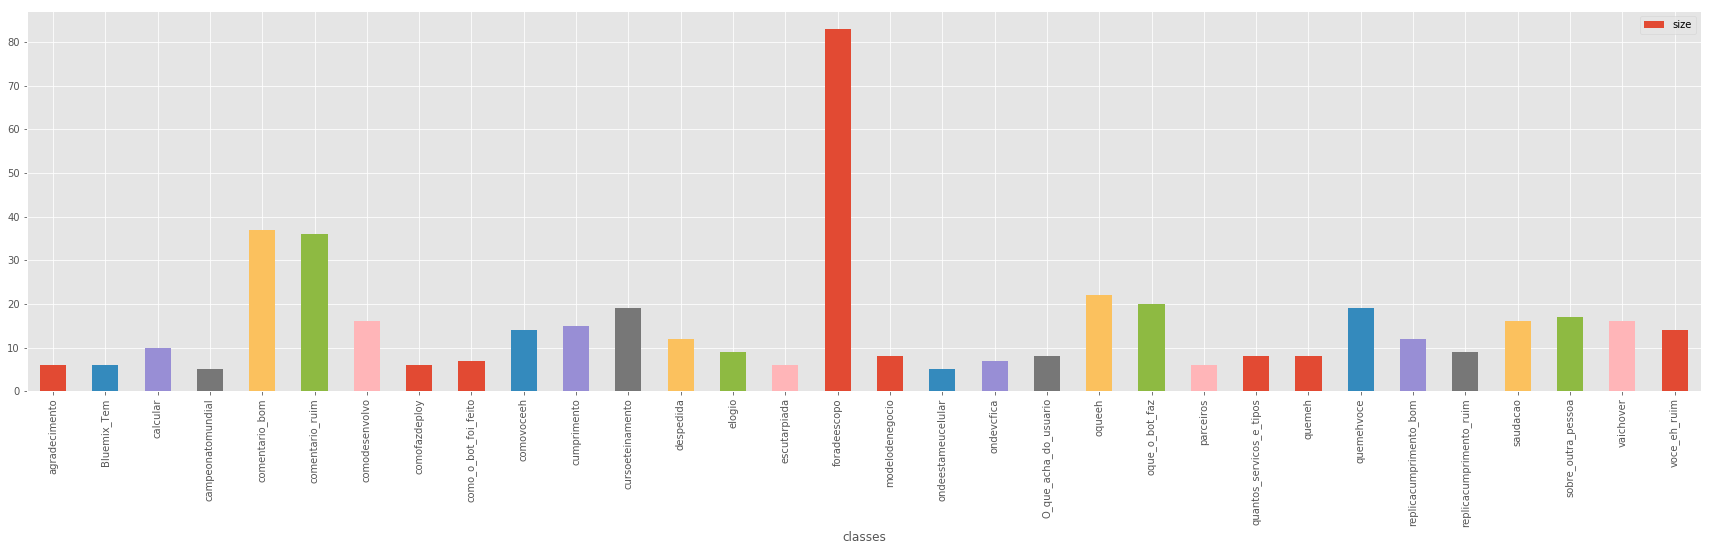

In [7]:
# Obter lista de intenções da exportação anterior do json
list_original_intents = assistant.list_intents(
    workspace_id = original_workspace_id
).get_result()

list_original_examples = []
list_original_intent_names = []

# Declaração de variável
intent_distribution = pd.DataFrame(columns=['classes', 'size'])
avg_size = 0;

# Visualização de distribuição de montagens
for idx, intent in enumerate(list_original_intents['intents']):
    examples = assistant.list_examples(
    workspace_id = original_workspace_id,
    intent = list_original_intents['intents'][idx]['intent']
    ).get_result()
    avg_size = avg_size + len(examples['examples'])
    for example in examples['examples']:
        list_original_examples.append(example['text'])
        list_original_intent_names.append(list_original_intents['intents'][idx]['intent'])
        intent_distribution.loc[idx] = pd.Series({'classes':list_original_intents['intents'][idx]['intent'], 'size': len(examples['examples'])})
        #avg_size = avg_size + len(examples['examples'])

# Imprime o gráfico na tela
intent_distribution.plot(kind='bar',x='classes', y='size',figsize=(30,7))

# Monta o quadro de dados
intent_distribution = pd.DataFrame({
    'Example': list_original_examples,
    'Intent': list_original_intent_names
}, columns=['Example','Intent'])

In [8]:
# Tamanho médio da intenção
final_avg_size = avg_size/len(list_original_intents['intents'])

print("Média de exemplos por intenção: " + str(final_avg_size))

Média de exemplos por intenção: 15.0625


### Por que concentrar exemplos em uma única intenção não é uma boa ideia:
#### <a id="adtpa"></a>Amostras Desequilibradas e Paradoxo da Precisão / Acuracidade

Um problema comum que encontramos ao trabalhar com dados está relacionado ao fato de que o número de ocorrências de um determinado evento não é, geralmente, balanceado. No nosso caso, as pessoas tendem a treinar chatbots sem considerar o número de exemplos por intenção e então se encontram com um bot que tem muitos exemplos para uma ou duas intenções e um pouco para o resto..

Na ciência de dados, chamamos isso de **amostra de treinamento desequilibrada** e seu impacto na qualidade do nosso modelo acontece porque algumas distorções são criadas em relação à sua falta de conhecimento. Considere o seguinte:

1. Temos um conjunto de treinamento com 90 exemplos positivos e 10 exemplos negativos.
2. Seu modelo é treinado com ele e assume que cada entrada deve ser classificada como positiva.
3. **Este é um modelo ruim?**
4. **Não necessariamente**, seu classificador tem 90% de precisão, o que é muito bom!
5. **Isto é útil?** Provavelmente não.

Então isso é chamado de **accuracy paradox** (https://en.wikipedia.org/wiki/Accuracy_paradox), ter um modelo que apresente boas métricas com uma amostra de treinamento, mas isso não é realmente útil. (Você pode aprender mais aqui: https://tryolabs.com/blog/2013/03/25/why-accuracy-alone-bad-measure-classification-tasks-and-what-we-can-do-about-it/)

Você também pode aprender algo sobre amostras desbalanceadas e como tratá-las com esses links:
* https://svds.com/learning-imbalanced-classes/ 
* https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

**Então, pelo que vimos, é bom manter sua amostra de treinamento com uma quantidade similar de exemplos!** Vamos ver como nosso classificador está fazendo isso.

In [10]:
# Coeficiente de discrepância
cte_coef_disc = 0.5

print(colored("\nIntenções com uma discrepância de exemplos (intenção # exemplos):\n", attrs=['bold']))

if final_avg_size < 5:
    print(colored(">>> A amostra apresentada não atende ao mínimo requerido para treinamento (5 exemplos) e, portanto, os desvios não serão calculados.", 'red', attrs=['bold']))
else:
    # Validação de quais classes estão "ofendendo" a distribuição
    for intent in list_original_intents['intents']:
        examples = assistant.list_examples(
        workspace_id = original_workspace_id,
        intent = intent['intent']
        ).get_result()

        diff = float(len(examples['examples'])) - final_avg_size
        if(abs(diff) > (final_avg_size * cte_coef_disc)):
            if diff > 0:
                printred("[+] >>> " + intent['intent'] + ' # ' + str(len(examples['examples'])) + ' / Tem ' + str(round(diff-(final_avg_size * cte_coef_disc),2)) + ' mais exemplos que o esperado.',True)
            else:
                printred("[-] >>> " + intent['intent'] + ' # ' + str(len(examples['examples'])) + ' / Tem ' + str(round(abs(diff)-(final_avg_size * cte_coef_disc),2)) + ' menos exemplos que o esperado.',True)
                    


Intenções com uma discrepância de exemplos (intenção # exemplos):

[-] >>> agradecimento # 6 / Tem 1.53 menos exemplos que o esperado.
[-] >>> Bluemix_Tem # 6 / Tem 1.53 menos exemplos que o esperado.
[-] >>> campeonatomundial # 5 / Tem 2.53 menos exemplos que o esperado.
[+] >>> comentario_bom # 37 / Tem 14.41 mais exemplos que o esperado.
[+] >>> comentario_ruim # 36 / Tem 13.41 mais exemplos que o esperado.
[-] >>> comofazdeploy # 6 / Tem 1.53 menos exemplos que o esperado.
[-] >>> como_o_bot_foi_feito # 7 / Tem 0.53 menos exemplos que o esperado.
[-] >>> escutarpiada # 6 / Tem 1.53 menos exemplos que o esperado.
[+] >>> foradeescopo # 83 / Tem 60.41 mais exemplos que o esperado.
[-] >>> ondeestameucelular # 5 / Tem 2.53 menos exemplos que o esperado.
[-] >>> ondevcfica # 7 / Tem 0.53 menos exemplos que o esperado.
[-] >>> parceiros # 6 / Tem 1.53 menos exemplos que o esperado.


##### Feito! Agora temos uma primeira idéia de quais classes ajustar, a fim de tornar nosso classificador mais preciso, mas como podemos melhorar essa análise??

### <a id="intentmin"></a>Exemplos mínimos por intenção
Outra análise que podemos fazer para garantir nosso melhor desempenho ao chatbot é com relação aos requisitos mínimos da API:

A documentação do Watson Assistant menciona a **precisa ter pelo menos cinco exemplos por intenção, mas a sugestão é alcançar até dez exemplos**. Vamos verificar se o seu chatbot atende a esses requisitos:

In [11]:
print(colored("\nIntenção sem quantidade mínima de exemplos (5):\n", attrs=['bold']))

# Verifica se o mínimo exigido foi cumprido
for intent in list_original_intents['intents']:
    examples = assistant.list_examples(
    workspace_id = original_workspace_id,
    intent = intent['intent']
    ).get_result()

    if len(examples['examples']) < 5:
        printred(">>> " + intent['intent'] + ' # ' + str(len(examples['examples'])),True)
        
print(colored("\n\nIntenção sem quantidade mínima de exemplos SUGERIDOS (10):\n", attrs=['bold']))

# Verifica se o mínimo sugerido foi cumprido
for intent in list_original_intents['intents']:
    examples = assistant.list_examples(
    workspace_id = original_workspace_id,
    intent = intent['intent']
    ).get_result()

    if len(examples['examples']) < 10:
        printred(">>> " + intent['intent'] + ' # ' + str(len(examples['examples'])),True)


Intenção sem quantidade mínima de exemplos (5):



Intenção sem quantidade mínima de exemplos SUGERIDOS (10):

>>> agradecimento # 6
>>> Bluemix_Tem # 6
>>> campeonatomundial # 5
>>> comofazdeploy # 6
>>> como_o_bot_foi_feito # 7
>>> elogio # 9
>>> escutarpiada # 6
>>> modelodenegocio # 8
>>> ondeestameucelular # 5
>>> ondevcfica # 7
>>> O_que_acha_do_usuario # 8
>>> parceiros # 6
>>> quantos_servicos_e_tipos # 8
>>> quemeh # 8
>>> replicacumprimento_ruim # 9


** As intenções que aparecem acima devem ser aquelas que você deve focar primeiro porque elas nem sequer atendem aos requisitos mínimos. Você deveria questionar a existência deles, eles são realmente necessários? Se não, então não coloque em seu modelo, nem mesmo se planeja usá-lo no futuro.**

### <a id="repeatedexamples"></a>Exemplos repetidos
Nossa última análise sobre exemplos de intenção está relacionada a ocorrências repetidas dela. Embora não seja proibido, ter exemplos repetidos em mais de uma intenção não é uma boa prática.

In [12]:
print(colored("\nSeleciona exemplos repetidos em nosso conjunto de treinamento:\n", attrs=['bold']))

# Mounts example frequency
fdist = nltk.FreqDist(intent_distribution['Example'])        

# Selecione aqueles com mais de uma ocorrência
repeated = [x for idx,x in intent_distribution.sort_values("Example").iterrows() if x['Example'] in [k for k,v in fdist.items() if v > 1]]
for y in repeated:
    print(y['Example'] + ' # ' + y['Intent'])
    
if len(repeated) <= 2:
    print(colored("Não há exemplos repetidos em nosso conjunto. Parabéns!", 'green'))


Seleciona exemplos repetidos em nosso conjunto de treinamento:

Não há exemplos repetidos em nosso conjunto. Parabéns!


## <a id="loganalysis"></a>Análise de histórico de log
Acompanhando nossa etapa de **compreensão de dados** do processo, agora analisaremos nosso comportamento do chatbot com entradas reais do usuário, as perguntas enviadas ao nosso bot no passado.

Vamos começar verificando a distribuição de intenção em nossos registros, assim como fizemos com nossos exemplos.

In [13]:
# Função auxiliar que chama o WAS para saída de log
# Por padrão vai trazer 100 últimas interações, por isso o uso do parametro page_limit
def mount_logs_dump(wid):
    response = assistant.list_logs(
    workspace_id = wid, page_limit = 200
    ).get_result()

    list_mount_examples = []
    list_mount_intents = []
    list_mount_intents2 = []
    list_mount_confidence = []
    list_mount_confidence2 = []
    
    cursor_regex = r".*?cursor=(.*?)&"

    while response and 'logs' in response:
    
        cont = 0
        for log in response['logs']:
            cont += 1
            if log["response"]:
                lresponse = log['response']
                
                if 'input' in lresponse and 'text' in lresponse['input']:
                    if 'intents' in lresponse and lresponse['intents']:
                        list_mount_examples.append(lresponse['input']['text'].strip())
                        list_mount_intents.append(lresponse['intents'][0]['intent'])
                        list_mount_confidence.append(lresponse['intents'][0]['confidence'])

                        if 'alternate_intents' in log['request'] and log['request']['alternate_intents'] == "true":
                            list_mount_intents2.append(lresponse['intents'][1]['intent'])
                            list_mount_confidence2.append(lresponse['intents'][1]['confidence'])
                        else:
                            list_mount_intents2.append('N/A')
                            list_mount_confidence2.append('0')
                    else:
                        list_mount_examples.append(lresponse['input']['text'].strip())
                        list_mount_intents.append('irrelevant')
                        list_mount_confidence.append('0')
                        list_mount_intents2.append('N/A')
                        list_mount_confidence2.append('0')
        
        if 'pagination' not in response or 'next_url' not in response['pagination']:
            print(response)
            break
    
        cursor_res = re.search(cursor_regex, response['pagination']['next_url'], re.IGNORECASE)
        cursor = None
    
        if cursor_res:
            cursor = cursor_res.group(1)
        if not cursor:
            break
     
        response = assistant.list_logs(workspace_id=wid, page_limit=1000, cursor=cursor)
    
    df_temp = pd.DataFrame({
        'Example': list_mount_examples,
        'Intent_1': list_mount_intents,
        'Confidence_1': list_mount_confidence,
        'Intent_2': list_mount_intents2,
        'Confidence_2': list_mount_confidence2,
    }, columns=['Example','Intent_1','Confidence_1','Intent_2','Confidence_2'])
    
    return df_temp

In [14]:
# Reunir logs de todas as conversas feitas no espaço de trabalho
list_logs = mount_logs_dump(original_workspace_id)

# Verifique se há logs em tudo
flag_logs = len(list_logs) > 0

In [15]:
# Monta o nosso quadro de dados para posterior visualização
if flag_logs:
    dist_logs = pd.DataFrame(columns=['intent', 'sizes','confidencesum'])

    # Não há necessidade de analisar esses
    intent_blacklist = ['greetings','fim']

    for idx,log in list_logs.iterrows():
        if log['Intent_1'] not in intent_blacklist:
            dist_logs.loc[idx] = pd.Series({'intent': log['Intent_1'], 'sizes': 1,'confidencesum': float(log['Confidence_1'])})

### <a id="meanconfidence"></a>Média geral de confiança

Poderíamos olhar apenas para a confiança média geral de nosso modelo em relação às entradas de usuários recebidas (e isso é um erro que muitas pessoas fazem). **Mas, como qualquer métrica ou técnica, devemos pensar sobre o que ela representa atualmente.**

Então vamos imaginar duas situações diferentes:

### Situação 1 - Distribuição inadequada de testes
Eu tenho um chatbot com apenas uma intenção bem treinada e todas as outras intenções têm um treinamento muito ruim (lembre-se do exemplo de exemplo desbalanceado?). **Devemos ter um número de confiança ruim, certo?** <font color='red'>**Na verdade não**</font>

* Se marcada apenas com o nosso histórico de log e cada entrada foi feita contra a intenção bem treinada, então teríamos um índice de confiança enganoso com um número alto. Isso não representa a realidade do nosso treinamento.
* **Isso significa que nosso bot não é bom o suficiente?** Não. Na verdade, ele responde o que precisa na maior parte do tempo, mas se perde com todo o resto. Ele faz o justo, não é tão inteligente.

**Quando isso geralmente acontece?** Vemos esse tipo de comportamento quando a mesma equipe cria e testa o bot. Eles sabem o que o bot deve responder e são tendenciosos para se restringir dentro das limitações do treinamento. <font color='red'>**É por isso que você deve testá-lo com pessoas que não o viram antes.**</font>

### Situação 2 - falsos positivos de alta confiança
**Isso é mais crítico porque pode levar a danos à imagem da empresa se isso acontecer:**

estamos falando de falsos positivos, ou seja, quando seu bot retorna altas confidências para intenções / respostas erradas. Imagine o mesmo bot como antes, mas com o seguinte resultado:
* Seus usuários estão fazendo muitas perguntas diferentes para as intenções restantes (não aquele com muitos exemplos) e sempre retorna a mesma intenção com alta confiança (digamos que pressupõe que cada entrada pertence a essa classe e retorna com 85% de confiança ). **Muito ruim né?**
* Agora imagine que a intenção retornada tem a resposta "É sempre bom conversar com você" e o usuário queria reclamar ou cancelar. Ou pior ainda, a resposta vem como algo agressivo para alguém.


**Este é um ótimo exemplo que nos mostra que usar a confiança devolvida sem contexto pode lhe dar o efeito oposto da medição..**

In [16]:
# Calcula a confiança média geral
if flag_logs:
    print("Média de confiança (com irrelevantes) > " + str(round(dist_logs['confidencesum'].mean()*100,2)) + " % ")
    print("Média de confiança (sem irrelevantes) > " + str(round(dist_logs[dist_logs['intent'] != 'irrelevant']['confidencesum'].mean()*100,2)) + " % ")

Média de confiança (com irrelevantes) > 78.51 % 
Média de confiança (sem irrelevantes) > 83.71 % 


**Então, vimos que a confiança média geral pode não ser uma boa demonstração do nível geral de precisão de nosso bot.**

### <a id="logdistribution"></a>Distribuição de registro e média de confiança por intenção

Agora que discutimos o que a confiança realmente significa e os problemas que ela poderia trazer, podemos fazer uma análise mais inteligente dela usando dois gráficos:
* Distribuição das perguntas mais frequentes.
* Média de confiança por intenção.

Com isso em mãos, podemos encontrar as perguntas mais frequentes que tiveram uma confiança menor do que a esperada e priorizá-las..

**Boas perguntas seriam:**
* Nossas principais intenções atingem um nível mínimo definido por nós?
* Em que intenção devo me concentrar primeiro?
* Para aqueles com menos que o mínimo: temos novos insumos suficientes para melhorar o treinamento?



Mais perguntou intenções com mais de 5 exemplos



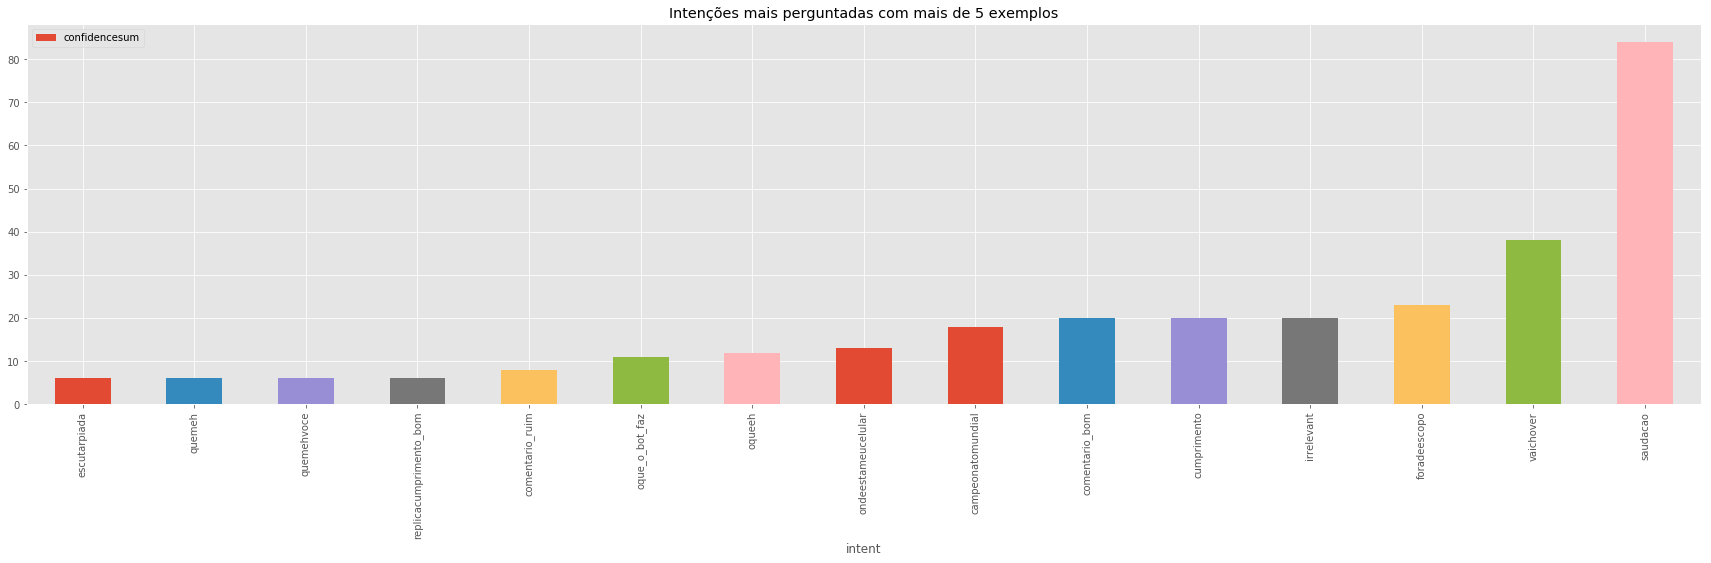

In [17]:
# Agrupa intenções, soma ocorrências e calcula a confiança média para cada.
if flag_logs:
    
    # Grupos de intenções
    grouped1 = dist_logs.groupby('intent').mean()
    grouped2 = dist_logs.groupby('intent').count()
    
    cte_logs = 5

    print(colored('Mais perguntou intenções com mais de ' + str(cte_logs) + ' exemplos\n', attrs=['bold']))
    grouped4 = grouped2.where(lambda x : x['sizes'] > cte_logs).dropna().sort_values(by='sizes')
    
    grouped4.index.name='intent'
    grouped4['intent']=grouped4.index
    
    # Mostra o log de distribuição na tela
    grouped4.plot(kind='bar',x='intent', y='confidencesum',figsize=(30,7),title='Intenções mais perguntadas com mais de ' + str(cte_logs) + ' exemplos')

In [18]:
if flag_logs:
    # Calcula a intersecção entre as séries
    df_intersection = pd.merge(grouped4, grouped1, left_index=True, right_index=True)
    df_intersection.drop('confidencesum_x', axis=1, inplace=True)
    
    print(colored('Média de confiança por intenção (com mais de ' + str(cte_logs) + ' exemplos):\n', attrs=['bold']))
    display(df_intersection.sort_values(by='confidencesum_y'))

Média de confiança por intenção (com mais de 5 exemplos):



,sizes,intent,confidencesum_y
intent,,,
irrelevant,20.0,irrelevant,0.000000
ondeestameucelular,13.0,ondeestameucelular,0.436310
comentario_bom,20.0,comentario_bom,0.555895
quemehvoce,6.0,quemehvoce,0.582626
comentario_ruim,8.0,comentario_ruim,0.684703
oque_o_bot_faz,11.0,oque_o_bot_faz,0.706548
foradeescopo,23.0,foradeescopo,0.719453
replicacumprimento_bom,6.0,replicacumprimento_bom,0.747954
oqueeh,12.0,oqueeh,0.838150


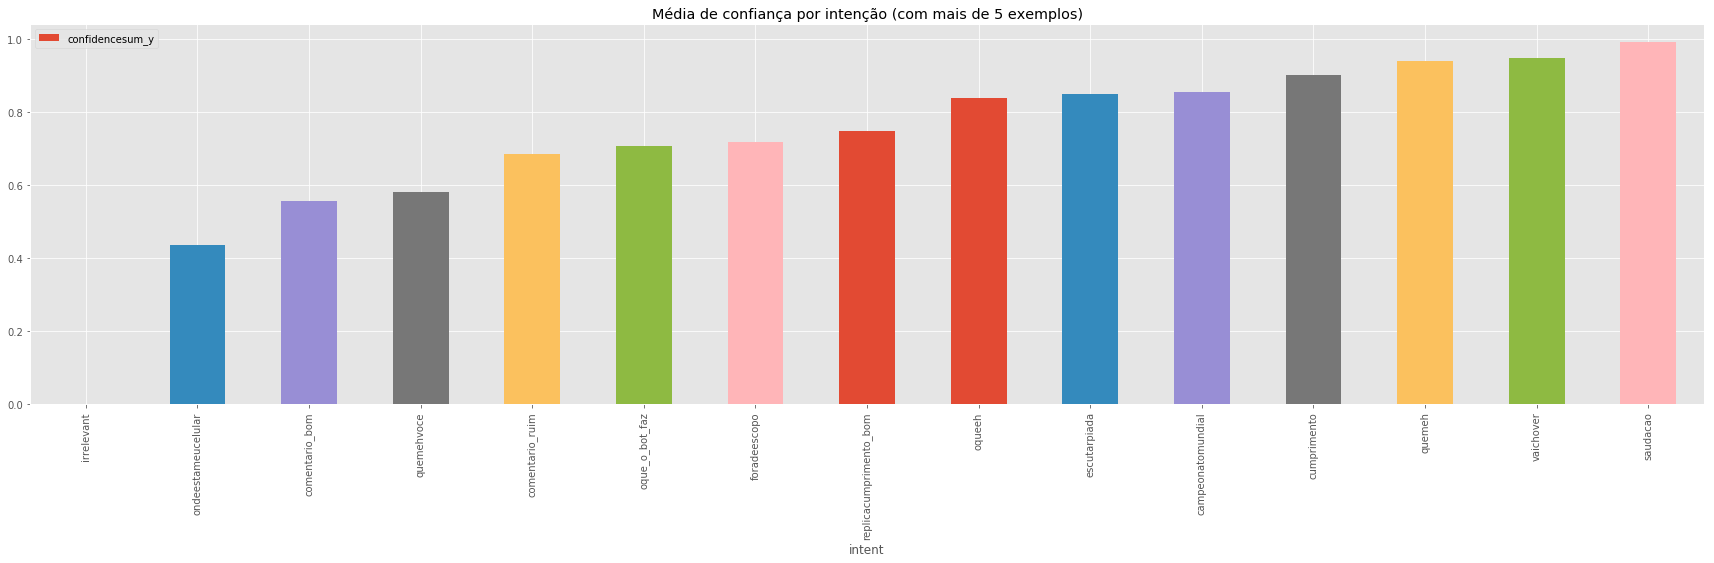

In [19]:
# Imprime gráfico com distribuição de log vs. confiança geral

if flag_logs:
    df_intersection.sort_values(by='confidencesum_y').plot(kind='bar',x='intent', y='confidencesum_y',figsize=(30,7),title='Média de confiança por intenção (com mais de ' + str(cte_logs) + ' exemplos)')

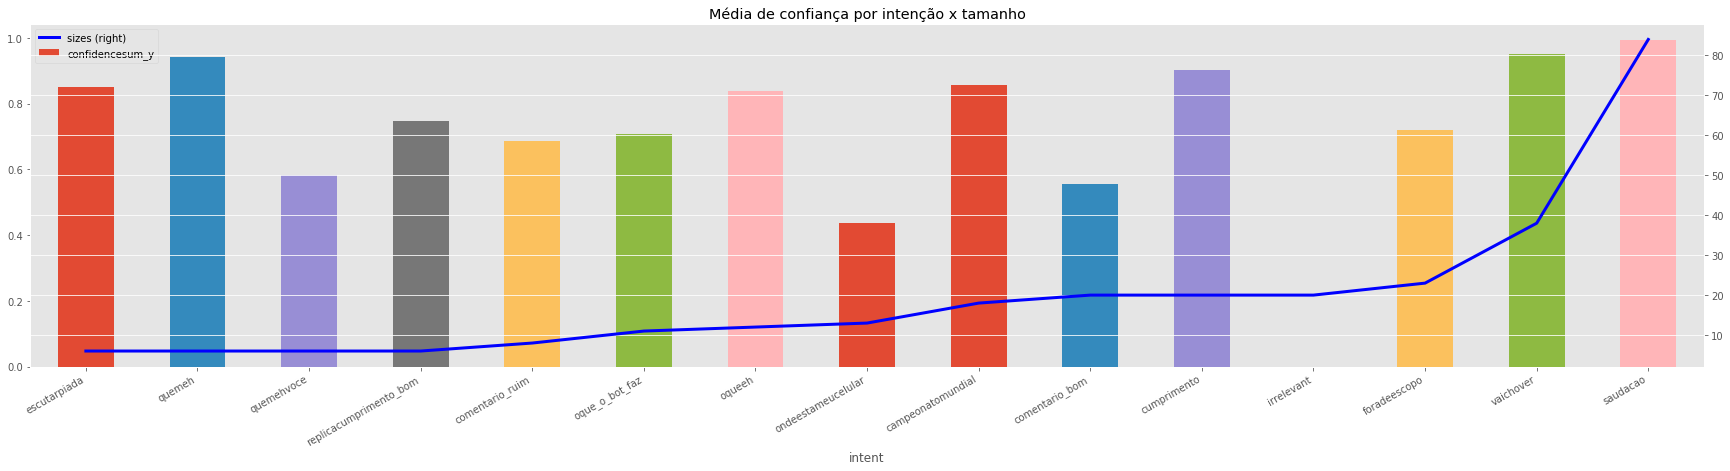

In [20]:
# Imprime gráficos combinados
if flag_logs:
    # Remove colunas desnecessárias
    grouped4.drop('confidencesum', axis=1, inplace=True)
    df_intersection.drop('sizes', axis=1, inplace=True)

    ax = grouped4.plot(kind='line',x='intent', y='sizes',figsize=(30,7),color='b',linewidth=3,secondary_y=True,legend=True)
    df_intersection.plot(ax=ax, kind='bar',x='intent', y='confidencesum_y',figsize=(30,7),title='Média de confiança por intenção x tamanho',legend=True)
    
    plt.gcf().autofmt_xdate()
    plt.show()

### (Entendendo o gráfico acima)
Uma boa abordagem aqui seria definir um limite mínimo para a confiança esperada e, em seguida, começar a analisar a intenção por intenção da direita para a esquerda.

### <a id="lowconfidence"></a>Exemplos com baixa confiança

Dependendo da quantidade de interações que o seu bot já teve iniciar um retreino pode parecer uma tarefa assustadora. Uma boa prática é começar o retreino do seu Assistant usando aqueles exemplos que tiveram um nível de confiança muito baixo, essas interações servirão para que você verifique a necessidade de criar novas intenções e/ou adicionar mais exemplos as intenções já existentes, lembrando que estes exemplos trarão mais impacto ao treinamento do que aqueles com alto nível de confiança.

In [21]:
MIN_CONFIDENCE = 0.5

if flag_logs:
    counter = 0
    arr_inputs = []
    arr_intents = []
    arr_confidence = []
    arr_repeated = []

    for idx,log in list_logs.iterrows():
        current_intent = log['Intent_1']

        if current_intent not in intent_blacklist and float(log['Confidence_1']) < MIN_CONFIDENCE:
            arr_repeated.append(log['Example'])

            if float(log['Confidence_1']) < MIN_CONFIDENCE and log['Example'] not in arr_inputs:
                counter = counter + 1
                arr_inputs.append(log['Example'])
                arr_intents.append(log['Intent_1'])
                arr_confidence.append(log['Confidence_1'])
    
    low_confidence = pd.DataFrame({
        'Example': arr_inputs,
        'Intent': arr_intents,
        'Confidence': arr_confidence,
    }, columns=['Example','Intent','Confidence'])

    print(display(arr_inputs[0:20]))

['Onde esta meu iphone',
 'Yes',
 'Se cuide!!',
 'Bluemix realiza verificação de fala?',
 'são bernardo do campo',
 'São Bernardo do campo',
 '😉',
 'Blue',
 'Ok',
 'Você já beijou alguém?',
 'Pau no seu cú',
 'O que é  enconstitucionalicimamente',
 'estou meio cansado',
 'Qual o seu sexo?',
 'O que sugere?',
 'corrupção',
 'Não me mande emojis, eu perdi meu saco',
 'Oii',
 'Poços de Caldas MG',
 'Computação quântica']

None


### <a id="manyquestions"></a>Perguntas mais frequentes

Outro bom ponto de partida para treinar seu chatbot pode ser aquelas perguntas feitas mais de uma vez sem um bom nível de confiança retornado.

In [22]:
if flag_logs:
    print(colored("\nSeleciona os exemplos com maior ocorrência (mais de 2 repetições) e menor confiança:\n", attrs=['bold']))

    fdist = nltk.FreqDist(arr_repeated)
    flag = False

    for k,v in sorted(fdist.items(), key=lambda t:t[-1], reverse=True):
        if v > 2:
            flag = True
            print("[" + str(v) + "] > ",k)
    if flag is False:
        print("Nenhum log repetido foi encontrado.")


Seleciona os exemplos com maior ocorrência (mais de 2 repetições) e menor confiança:

[13] >  Onde esta meu iphone
[3] >  Ok


## <a id="advanced"></a>Etapa 4 - Análise Avançada

Para que possamos analisar a qualidade do nosso chatbot com um pouco mais de profundidade precisamos antes conhecer alguns conceitos:

Primeiro temos que ter em mente que a tarefa de identificar em qual classe (intenção) um input (exemplo) pertence é uma tarefa de classificação estatística (https://en.wikipedia.org/wiki/Statistical_classification) e portanto devemos utilizar métodos específicos para fazer a avaliação deste tipo de tarefa.

Ainda sobre conceitos, considere o problema de verificar se um input pertence a intenção #resetarSenha:
* **True positive (TP)** ou Verdadeiros Positivos (VP): casos em que retornamos a classe correta, o modelo preveu que a classe era #resetarSenha.
* **False positives (FP)** ou Falsos positivos (FP): casos em que retornamos falando que era a classe #resetarSenha quando na verdade era outra.
* **True Negative (TN)** ou Falsos Verdadeiros (FV): casos que retornamos que era outra classe e realmente era.
* **False Negative (FN)** ou Falsos Negativos (FN): retornamos que era outra classe quando na verdade era #resetarSenha.
* **Matriz de Confusão**: traz uma análise visual dos conceitos apresentados acima. 

** Todos esses conceitos são melhores explorados nos seguintes links: **
* https://medium.com/as-m%C3%A1quinas-que-pensam/m%C3%A9tricas-comuns-em-machine-learning-como-analisar-a-qualidade-de-chat-bots-inteligentes-introdu-57ff30424192
* https://medium.com/as-m%C3%A1quinas-que-pensam/m%C3%A9tricas-comuns-em-machine-learning-como-analisar-a-qualidade-de-chatbots-inteligentes-conceitos-a5b586053973
* https://medium.com/as-m%C3%A1quinas-que-pensam/m%C3%A9tricas-comuns-em-machine-learning-como-analisar-a-qualidade-de-chat-bots-inteligentes-m%C3%A9tricas-1ba580d7cc96

** Obs: por questões de custos vamos fazer uma análise mais simples baseada em amostragem, no fim deste notebook abordaremos outros métodos que podem ser utilizados para medir o seu chatbot com ainda mais precisão. **
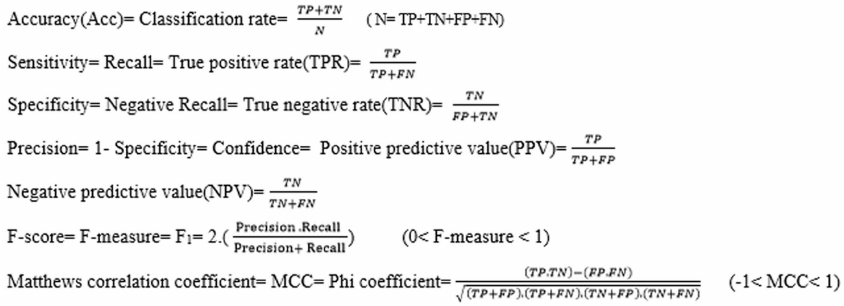

In [27]:
# Monta o dataframe para ser trabalhado com
le_examples = []
le_intents = []

for intent in list_original_intents['intents']:
    examples = assistant.list_examples(
    workspace_id = original_workspace_id,
    intent = intent['intent']
    ).get_result()
        
    for ex in examples['examples']:
        le_examples.append(ex['text'])
        le_intents.append(intent['intent'])
        
list_ml_examples = pd.DataFrame({
    'Example': le_examples,
    'Intent': le_intents,
}, columns=['Example','Intent'])

agradecimento - Exemplo: Great tnks
agradecimento - Exemplo: Muito obrigado
agradecimento - Exemplo: Muito show!!
agradecimento - Exemplo: Obrigado
agradecimento - Exemplo: Te agradeço muito pela ajuda
agradecimento - Exemplo: Valeu!
Bluemix_Tem - Exemplo: A plataforma tem algum serviço de reconhecimento de pessoas?
Bluemix_Tem - Exemplo: A plataforma tem API de reconhecimento de texto?
Bluemix_Tem - Exemplo: Bluemix tem OCR?
Bluemix_Tem - Exemplo: Esta plataforma tem serviço de chatbot?
Bluemix_Tem - Exemplo: O Bluemix  tem serviço de reconhecimento de voz?
Bluemix_Tem - Exemplo: Tem API para higienização de dados?
calcular - Exemplo: calcular o preço do blockchain
calcular - Exemplo: Como calcular o custo de minha solução?
calcular - Exemplo: Como estimo quanto vou gastar?
calcular - Exemplo: Como sei quanto vou gastar?
calcular - Exemplo: e para saber o preço de aplicação java?
calcular - Exemplo: É possível saber quanto vou pagar?
calcular - Exemplo: Posso estimar o custo da soluçã

#### <a id="amostragem"></a>Amostragem

Como mencionado acima vamos testar nosso bot baseado em amostragem e para isso precisamos separar os datasets entre treino e teste respeitando uma proporção pré-determinada de 80/20, sendo que o conjunto de treino será aquele que efetivamente utilizaremos para treinar um novo modelo e o conjunto de teste nós utilizaremos para submeter ao novo modelo criado e verificar se o resultado é o mesmo que o esperado.

Obs: esse método não funciona tão bem quando temos uma amostra muito pequena pois o modelo treinado terá poucos insumos com o que aprender.

In [ ]:
# Como precisamos enviar alguns exemplos para testar o modelo, essa tarefa pode gerar custos se você já ultrapassou as dez mil solicitações mensais gratuitas.
length_test_set = len(list_ml_examples)*0.2*3
print("Exemplos: "+ str(len(list_ml_examples)*0.2*3))

print(colored('ATENÇÃO! Ao executar este teste, você pode ser cobrado até ' + str(round(length_test_set*0.00484,2)) + ' reais. Those costs are associated with ' 
              + str(round(length_test_set)) + ' chamadas para ser feito para o seu espaço de trabalho! Digite OK para aceitar...','red', attrs=['bold']))

acceptance = input()

if acceptance == 'OK'or acceptance == 'Ok'or acceptance == 'ok':
    print('Ok! Vamos continuar...')

In [86]:
# Função auxiliar que agrupa intenções e monta um array que o WAS pode entender. Também valida o número de exemplos em cada intenção.
def group_and_mount_intents(train_set):
    
    intents = {}
    
    # Grupos de intenções
    for idx, example in train_set.iterrows():
        current_intent = example['Intent']
        
        if current_intent not in intents: 
            intents[current_intent] = []

        intents[current_intent].append(example['Example'])
        

    workspace_intens = []
    
    # Transforma o formato de intenção para o aceito pelo WAS
    for intent, examples in intents.items():
        entry = {'intent': intent, 'examples': []}
        if len(examples) < 10:
            print("[ATENÇÃO] Intenção #" + intent + " tem poucos exemplos [" + str(len(examples)) + "] do que o esperado e, portanto, não é um bom exemplo para este teste.")

        for example in examples:
            entry['examples'].append({ 'text': example })

        workspace_intens.append(entry)

    print('\nIntenções montadas.')

    return workspace_intens

In [87]:
# Função auxiliar que cria um novo espaço de trabalho para executar testes sem danificar o chatbot atual
def create_test_workspace(train_set):
    intents_json = group_and_mount_intents(train_set)
    
    entities_list = assistant.list_entities(
        workspace_id = original_workspace_id
    ).get_result()    
    
    response = assistant.create_workspace(name = 'Gerado_por_Watson_Studio', entities = entities_list['entities'], intents = intents_json, language = 'pt-br')

    print('Skill / Workspace criado, aguarde ficar pronto...')
        
    print(response.result["workspace_id"])

    check_wksp_status(response.result["workspace_id"])
            
    return response.result["workspace_id"]

In [88]:
def mount_confusion_matrix(test_set,teste_wid):
    cm_predicted = []
    cm_predicted_2 = []

    cm_conf_p1 = []
    cm_conf_p2 = []
    cm_delta = []

    cm_true = []
    cm_true_q = []
    
    for index, row in test_set.iterrows():
        message = { 'text': row['Example'] }
        
        response = assistant.message(workspace_id=teste_wid,input=message,alternate_intents=True).get_result()

        if response['intents'] != []:
            cm_true_q.append(row['Example'])
            cm_true.append(row['Intent'])
            cm_predicted.append(response['intents'][0]['intent'])
            cm_conf_p1.append(response['intents'][0]['confidence'])

            if len(response['intents']) > 1:
                cm_predicted_2.append(response['intents'][1]['intent'])
                cm_conf_p2.append(response['intents'][1]['confidence'])
                cm_delta.append(float(response['intents'][0]['confidence']) - float(response['intents'][1]['confidence']))
            else:
                cm_predicted_2.append('irrelevant')
                cm_conf_p2.append(0)
                cm_delta.append(1)
    
    resultados = pd.DataFrame({
        'Question': cm_true_q,
        'True': cm_true,
        'Predicted_1': cm_predicted,
        'Predicted_2': cm_predicted_2,
        'Conf_1': cm_conf_p1,
        'Conf_2': cm_conf_p2,
        'Delta': cm_delta
    }, columns=['Question','True','Predicted_1','Predicted_2','Conf_1','Conf_2','Delta','Missed'])

    resultados['Missed'] = resultados.apply(lambda x : 'X' if x['True'] != x['Predicted_1'] else '', axis=1)
    
    return resultados, cm_true, cm_predicted, cm_predicted_2

In [89]:
def plot_confusion_matrix(cm, classes=None, normalize=False, title='', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusão normalizada")
    else:
        print('Matriz de confusão, sem normalização')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Resultados de Execução ML

Como uma estratégia de amostragem, executamos uma divisão 80/20 três vezes e depois calculamos as pontuações resultantes. Se executado apenas quando seus resultados não forem confiáveis devido à dependência na seleção aleatória da amostra, faremos isso pelo menos três vezes para reduzir o erro.

In [90]:
N_ROUNDS = 1
run_wids = []
run_total_df_result = pd.DataFrame(columns=['Question','True','Predicted_1','Predicted_2','Conf_1','Conf_2','Delta','Missed'])
run_total_true = []
run_total_predicted = []
run_total_predicted_2 = []

for run_counter in range(0,N_ROUNDS):
    
    # Divide os conjuntos de treino e teste com uma proporção de 80/20
    X_train, X_test, y_train, y_test = train_test_split(list_ml_examples, list_ml_examples.Intent, test_size=0.2, stratify=list_ml_examples.Intent)
    
    # Cria Skill / Workspace para teste
    test_wid = create_test_workspace(X_train)
    
    run_temp_result, run_temp_true, run_temp_predicted, run_temp_predicted_2 = mount_confusion_matrix(X_test,test_wid)
    
    run_wids.append(test_wid)
    run_total_df_result = pd.concat([run_total_df_result,run_temp_result])
    run_total_true = run_total_true + run_temp_true
    run_total_predicted = run_total_predicted + run_temp_predicted
    run_total_predicted_2 = run_total_predicted + run_temp_predicted_2
    
    run_counter = run_counter + 1
    
    # Exclui automatiamente o Skill / Workspace criado para teste
    assistant.delete_workspace(workspace_id=test_wid)


[ATENÇÃO] Intenção #modelodenegocio tem poucos exemplos [6] do que o esperado e, portanto, não é um bom exemplo para este teste.
[ATENÇÃO] Intenção #quemeh tem poucos exemplos [6] do que o esperado e, portanto, não é um bom exemplo para este teste.
[ATENÇÃO] Intenção #elogio tem poucos exemplos [7] do que o esperado e, portanto, não é um bom exemplo para este teste.
[ATENÇÃO] Intenção #escutarpiada tem poucos exemplos [5] do que o esperado e, portanto, não é um bom exemplo para este teste.
[ATENÇÃO] Intenção #como_o_bot_foi_feito tem poucos exemplos [6] do que o esperado e, portanto, não é um bom exemplo para este teste.
[ATENÇÃO] Intenção #campeonatomundial tem poucos exemplos [4] do que o esperado e, portanto, não é um bom exemplo para este teste.
[ATENÇÃO] Intenção #comofazdeploy tem poucos exemplos [5] do que o esperado e, portanto, não é um bom exemplo para este teste.
[ATENÇÃO] Intenção #calcular tem poucos exemplos [8] do que o esperado e, portanto, não é um bom exemplo para est

In [91]:
class_names = run_total_df_result['True'].drop_duplicates().tolist()
class_names.append('irrelevant')

figure_size = (50,50)
mpl.rcParams['figure.figsize'] = figure_size

### Matriz de Confusão

Para entender uma matriz de confusão (cm), você deve entender que para cada classe x:
* Verdadeiros positivos: posição diagonal, cm (x, x).
* Falso positivos: soma da coluna x (sem diagonal principal), soma (cm (: x)) - cm (x, x).
* Falso negativos: soma da linha x (sem diagonal principal), soma (cm (x, :), 2) - cm (x, x).

Matriz de confusão, sem normalização


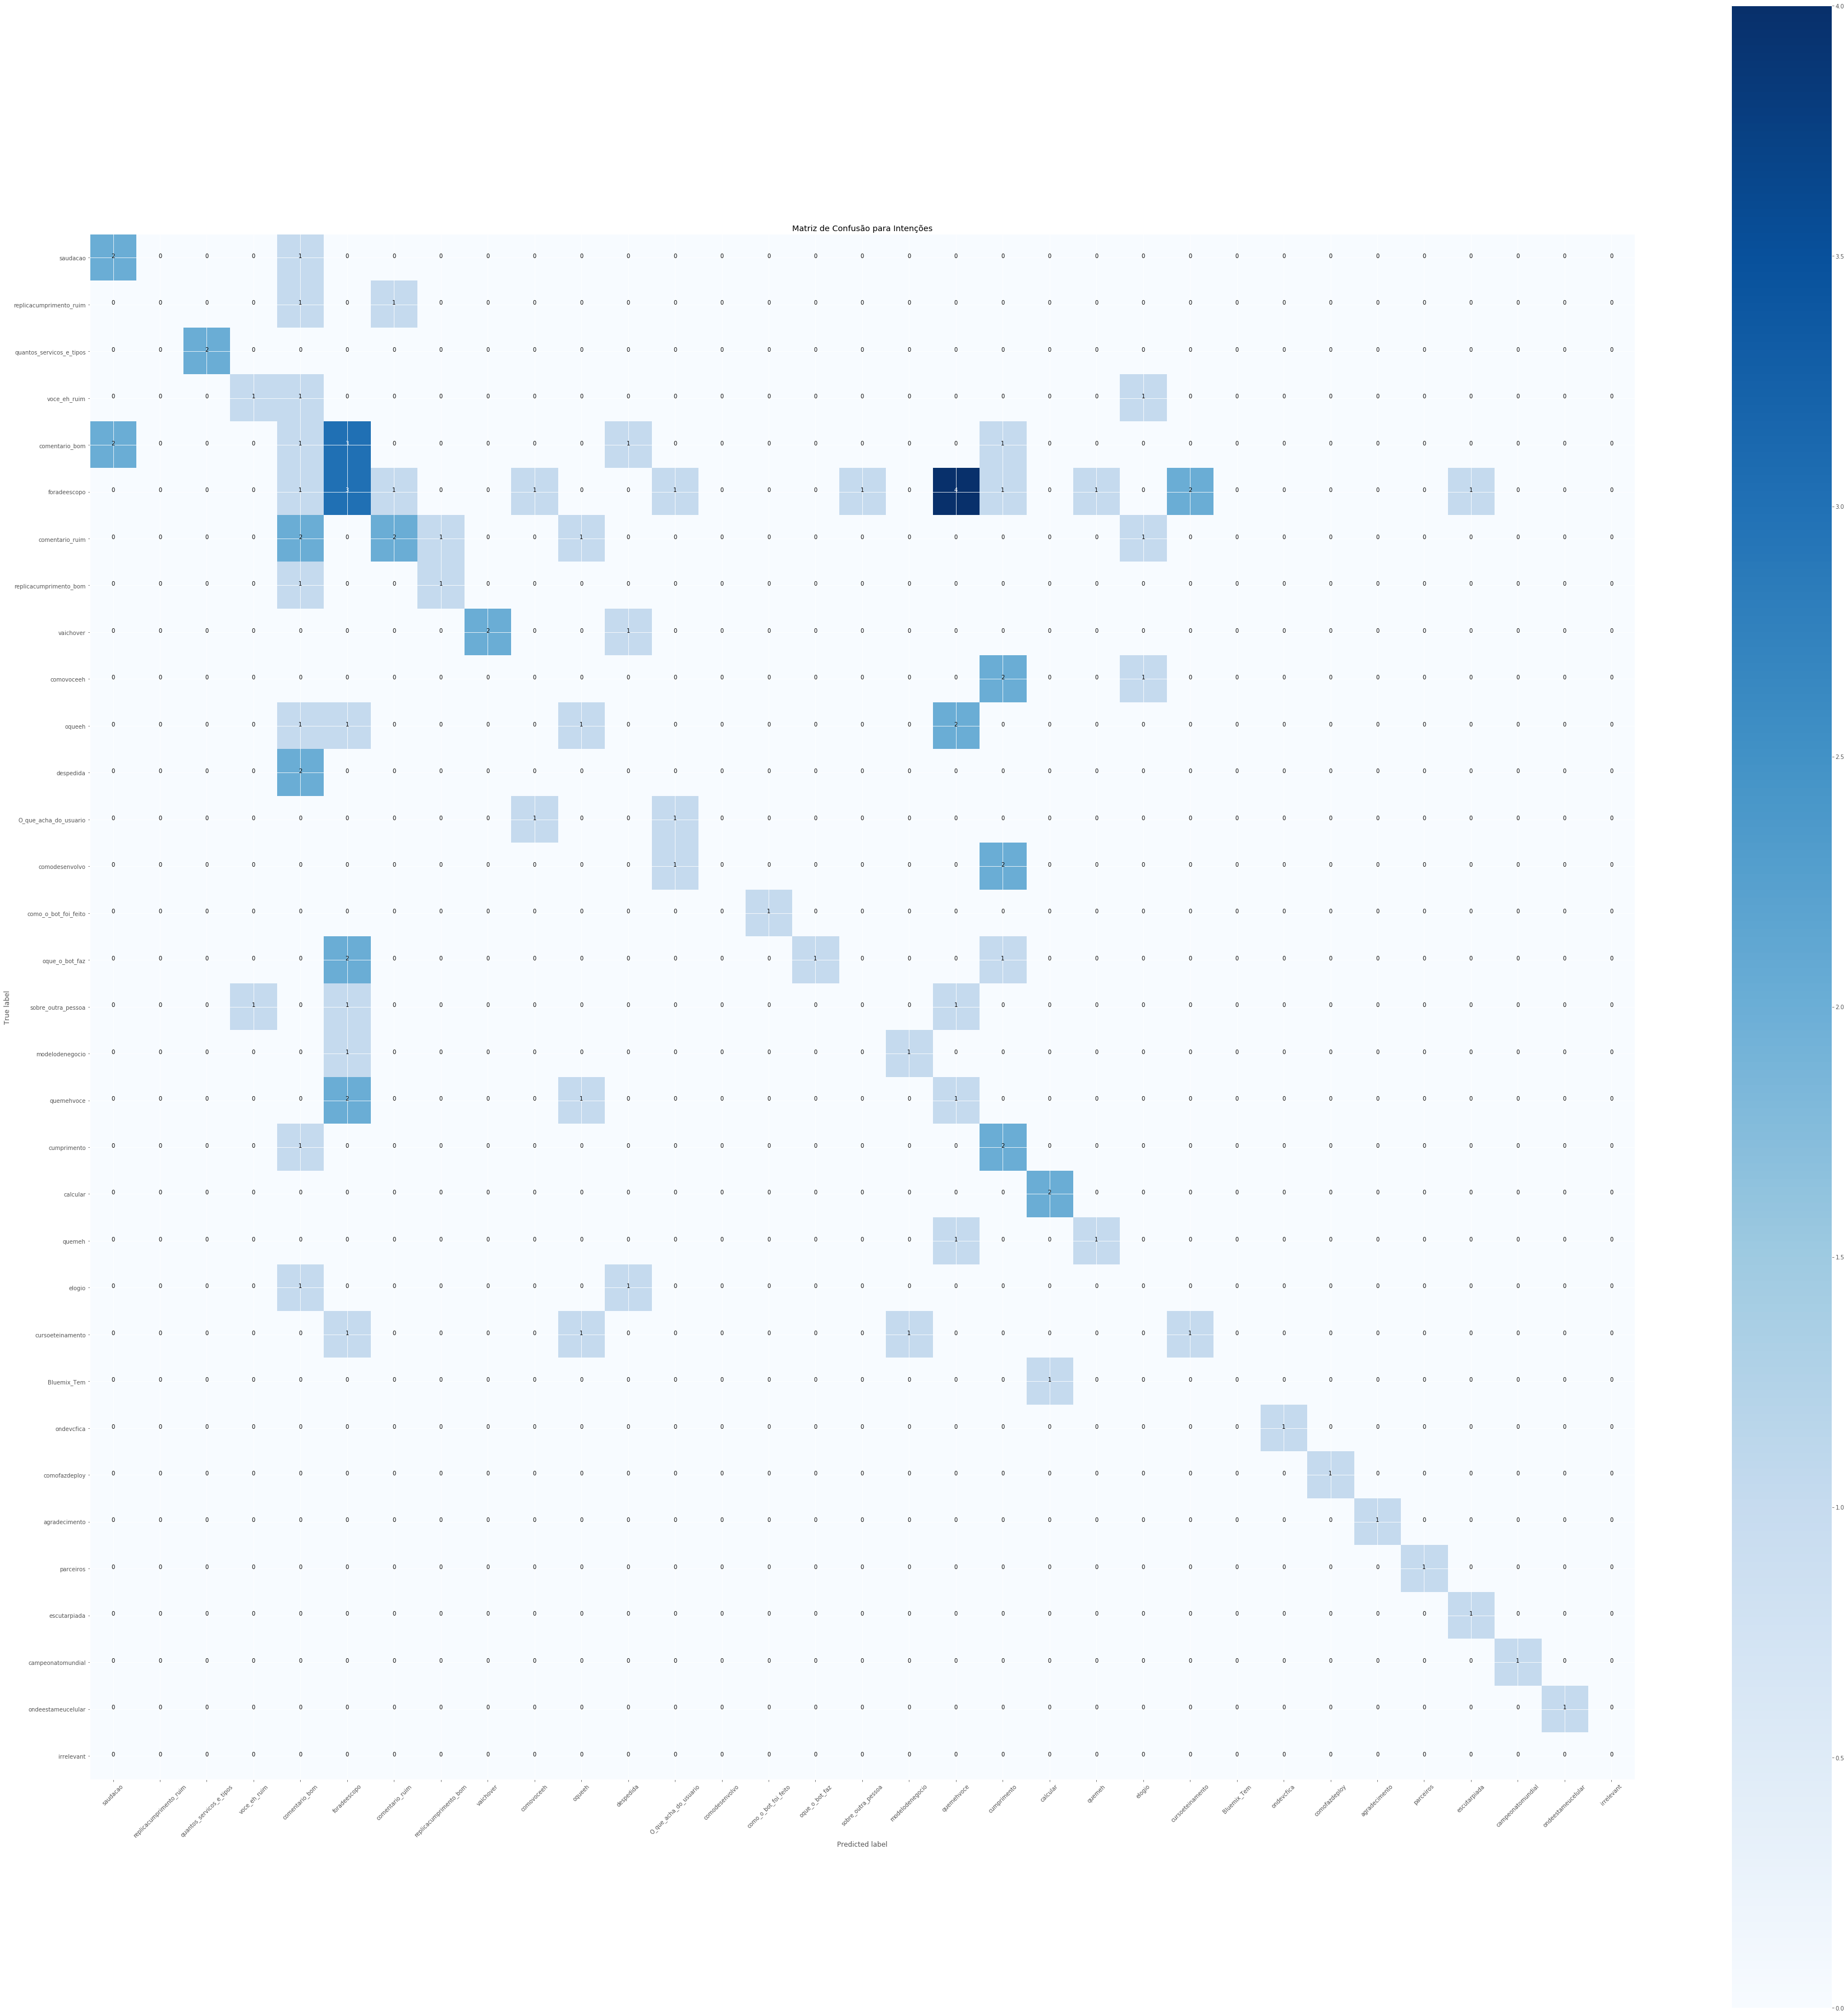

In [95]:
cnf_matrix = confusion_matrix(run_total_true, run_total_predicted, labels=class_names)
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Matriz de Confusão para Intenções')

In [96]:
print("Precisão")
print("Weighted: " + str(precision_score(run_total_true, run_total_predicted, average='weighted')))

print("\n\nRecall")
print("Weighted: " + str(recall_score(run_total_true, run_total_predicted, average='weighted')))

print("\n\nF1")
print("Weighted: " + str(f1_score(run_total_true, run_total_predicted, average='weighted')))


Precisão
Weighted: 0.370646249512


Recall
Weighted: 0.340206185567


F1
Weighted: 0.334515331323


/gpfs/fs01/user/scb4-547fcd10f85a8a-6a9412c8378f/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/gpfs/fs01/user/scb4-547fcd10f85a8a-6a9412c8378f/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [97]:
# Métricas para cada intenção
print(classification_report(run_total_true, run_total_predicted))

                          precision    recall  f1-score   support

             Bluemix_Tem       0.00      0.00      0.00         1
   O_que_acha_do_usuario       0.33      0.50      0.40         2
           agradecimento       1.00      1.00      1.00         1
                calcular       0.67      1.00      0.80         2
       campeonatomundial       1.00      1.00      1.00         1
          comentario_bom       0.08      0.12      0.10         8
         comentario_ruim       0.50      0.29      0.36         7
    como_o_bot_foi_feito       1.00      1.00      1.00         1
          comodesenvolvo       0.00      0.00      0.00         3
           comofazdeploy       1.00      1.00      1.00         1
              comovoceeh       0.00      0.00      0.00         3
             cumprimento       0.22      0.67      0.33         3
        cursoeteinamento       0.33      0.25      0.29         4
               despedida       0.00      0.00      0.00         2
         

/gpfs/fs01/user/scb4-547fcd10f85a8a-6a9412c8378f/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
